In [ ]:
%cd /content/drive/MyDrive/NLP/pytorch

/content/drive/MyDrive/NLP/pytorch


In [ ]:
import os
import math
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
from torchtext.legacy import data, datasets

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

TEXT = data.Field(lower=True, batch_first=True, eos_token='<eos>', pad_token=None)
train, val, test = datasets.PennTreebank.splits(TEXT)
TEXT.build_vocab(train)

print(TEXT.vocab.itos[34])
print(TEXT.vocab.stoi['them'])

Using device: cuda
have
127


In [ ]:
""" Define model
"""
class MyLSTM(nn.Module):
	def __init__(self, vocab_size, embedding_dim, hidden_size, dropout):
		super(MyLSTM, self).__init__()

		# Define architecture
		self.embeddings = nn.Embedding(vocab_size, embedding_dim)
		self.drop1 = nn.Dropout(dropout)
		self.lstm1 = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
		self.drop2 = nn.Dropout(dropout)
		self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
		self.drop3 = nn.Dropout(dropout)
		self.fc = nn.Linear(hidden_size, vocab_size)

		# Initialize weight
		nn.init.normal_(self.embeddings.weight, std=0.01)
		nn.init.normal_(self.lstm1.weight_ih_l0, std=1/math.sqrt(embedding_dim))
		nn.init.normal_(self.lstm1.weight_hh_l0, std=1/math.sqrt(hidden_size))
		nn.init.zeros_(self.lstm1.bias_ih_l0)
		nn.init.zeros_(self.lstm1.bias_hh_l0)
		nn.init.normal_(self.lstm2.weight_ih_l0, std=1/math.sqrt(embedding_dim))
		nn.init.normal_(self.lstm2.weight_hh_l0, std=1/math.sqrt(hidden_size))
		nn.init.zeros_(self.lstm2.bias_ih_l0)
		nn.init.zeros_(self.lstm2.bias_hh_l0)

		# Tie weights
		# Linear layers have weights of (output_dim, input_dim) shape
		self.fc.weight = self.embeddings.weight
		nn.init.zeros_(self.fc.bias)

	def forward(self, inputs, hidden1_prev, hidden2_prev):
		embeds = self.drop1(self.embeddings(inputs))
		out, hidden1_next = self.lstm1(embeds, hidden1_prev)
		out = self.drop2(out)
		out, hidden2_next = self.lstm2(out, hidden2_prev)
		out = self.drop3(out)
		out = self.fc(out)
		return out, hidden1_next, hidden2_next


def eval_perplexity(model, dataset):
	total_loss = 0.0
	hidden1, hidden2 = None, None

	with torch.no_grad():
		model.eval()

		for data in dataset:
			x, t = data.text, data.target
			x, t = x.to(DEVICE), t.to(DEVICE)
			output, hidden1, hidden2 = model(x, hidden1, hidden2)
			loss = criterion(output.view(-1, vocab_size), t.view(-1))
			total_loss += loss.item()

		ppl = math.exp(total_loss / len(dataset))
		return ppl

In [ ]:
""" Set hyperparameters
"""
max_epoch = 40
batch_size = 20
vocab_size = len(TEXT.vocab)
embedding_dim = 650
hidden_size = 650
dropout = 0.5
bptt_len = 35
lr = 20.0
max_norm = 0.25


model = MyLSTM(vocab_size, embedding_dim, hidden_size, dropout).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)
train_set, val_set, test_set = data.BPTTIterator.splits(
		(train, val, test), batch_size=batch_size, bptt_len=bptt_len, device=DEVICE
	)

print(len(train_set))

1328


In [ ]:
""" Training loop
"""
# PATH = os.path.join(os.path.dirname(__file__), '.checkpoint')
PATH = '.checkpoint'
os.makedirs(PATH, exist_ok=True)

total_loss = 0.0
count = 0
ppl_list = []
best_ppl = float('inf')
start_time = time.time()

for epoch in range(max_epoch):
	model.train()

	total_loss = 0.0
	hidden1, hidden2 = None, None

	for i, data in enumerate(train_set):
		x, t = data.text, data.target
		x, t = x.to(DEVICE), t.to(DEVICE)
		optimizer.zero_grad()

		output, hidden1, hidden2 = model(x, hidden1, hidden2)

		loss = criterion(output.view(-1, vocab_size), t.view(-1))
		total_loss += loss.item()
		count += 1
		loss.backward()
		nn.utils.clip_grad_norm_(model.parameters(), max_norm)
		optimizer.step()

		hidden1 = tuple(h.detach() for h in hidden1)
		hidden2 = tuple(h.detach() for h in hidden2)

		if i % 100 == 0:
			ppl = math.exp(total_loss / count)
			ppl_list.append(ppl)
			total_loss, count = 0.0, 0
			print(f'[epoch] {epoch+1} / {max_epoch} | iters {i+1} / {len(train_set)} | time {time.time() - start_time:.1f}[s] | perplexity {ppl:.2f}')

	val_ppl = eval_perplexity(model, val_set)
	if val_ppl < best_ppl:
		best_ppl = val_ppl
	else:
		lr /= 4.0
		for group in optimizer.param_groups:
			group['lr'] = lr

	print(f'\n[validation] perplexity {val_ppl:.2f} | best ppl {best_ppl:.2f}\n')
 	
   # Save parameters
	checkpoint = f'checkpoint_e{epoch+1}.pth'
	model_path = os.path.join(PATH, checkpoint)
	torch.save(model.state_dict(), model_path) 

[epoch] 1 / 40 | iters 1 / 1328 | time 0.3[s] | perplexity 10000.32
[epoch] 1 / 40 | iters 101 / 1328 | time 7.6[s] | perplexity 1548.77
[epoch] 1 / 40 | iters 201 / 1328 | time 14.8[s] | perplexity 735.24
[epoch] 1 / 40 | iters 301 / 1328 | time 22.0[s] | perplexity 562.86
[epoch] 1 / 40 | iters 401 / 1328 | time 29.3[s] | perplexity 446.61
[epoch] 1 / 40 | iters 501 / 1328 | time 36.5[s] | perplexity 389.50
[epoch] 1 / 40 | iters 601 / 1328 | time 43.7[s] | perplexity 352.63
[epoch] 1 / 40 | iters 701 / 1328 | time 50.9[s] | perplexity 308.32
[epoch] 1 / 40 | iters 801 / 1328 | time 58.2[s] | perplexity 271.11
[epoch] 1 / 40 | iters 901 / 1328 | time 65.4[s] | perplexity 262.84
[epoch] 1 / 40 | iters 1001 / 1328 | time 72.6[s] | perplexity 258.13
[epoch] 1 / 40 | iters 1101 / 1328 | time 79.8[s] | perplexity 226.38
[epoch] 1 / 40 | iters 1201 / 1328 | time 87.0[s] | perplexity 225.55
[epoch] 1 / 40 | iters 1301 / 1328 | time 94.2[s] | perplexity 209.54

[validation] perplexity 199.64

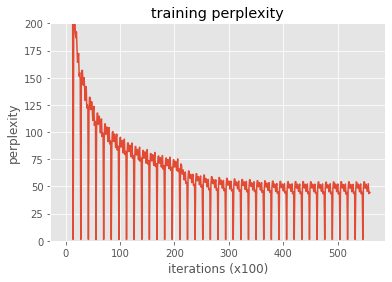

In [ ]:
""" Plot results
"""
import numpy as np

plt.style.use('ggplot')
plt.plot(np.arange(len(ppl_list)), ppl_list)
plt.title('training perplexity')
plt.xlabel('iterations (x100)')
plt.ylabel('perplexity')
plt.ylim(0.0, 200.0)
plt.show()

In [ ]:
""" Evaluation
"""
ppl = eval_perplexity(model, test_set)
print(f'\n[eval] perplexity {val_ppl:.2f} | best val ppl {best_ppl:.2f}\n')


[eval] perplexity 80.35 | best val ppl 80.35



In [ ]:
def generate_text(model, text, next_n_words=100, ignore=['<unk>']):
  model.eval()

  words = text.split(' ')
  hidden1, hidden2 = None, None

  for i in range(next_n_words):
    x = torch.tensor([[TEXT.vocab.stoi[w] for w in words[i:]]])
    x = x.to(DEVICE)
    output, hidden1, hidden2 = model(x, hidden1, hidden2)

    last_word_probs = output[0][-1]
    p = nn.functional.softmax(last_word_probs, dim=0).detach().cpu().numpy()
    word_idx = np.random.choice(len(last_word_probs), p=p)
    
    while TEXT.vocab.itos[word_idx] in ignore:
      word_idx = np.random.choice(len(last_word_probs), p=p)

    words.append(TEXT.vocab.itos[word_idx])

  print(f'> Generating text with sequence: {text}\n')
  print(' '.join(words).replace('<eos>', '.'))

In [ ]:
text = 'i have'
generate_text(model, text, next_n_words=100)

> Generating text with sequence: i have

i have surrendered shopping yourself the promise surrounding . because of the happening we say would remember most are the same thing as the court of the arabs . and look for a while . it was not as high as interest payments . one thing was in this case because you do n't option congress anymore toward blacks have an edge . we are not going to be making a mess folk . it 's the right to tell this thing is that members are not asking if mr. dinkins seems the hard drive . now it 's not that it
